In [1]:
from IPython.display import display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")
from fancyimpute import KNN
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, cross_val_score, KFold,train_test_split
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor,RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

## Approach

In my attempt to predict revenue, I had issues with handling my dependent variable. First, I estimated my total revenue by taking average monthly revenue and multiplying it by 6. The results of this model you see below. Then I used a regressor to predict revenue based on customer loyalty, brand awareness, income, age and so on. However, the model does not predict very well. Then I tried to estimate lifetime value by taking average purchase value multiplied by number of transactions and by retention time period. That was the formula I found online. However, it did not work well either and results were even worse (https://github.com/dmarinav/MyProjectsPortfolio/blob/master/PREDICT_REVENUE_2.ipynb), so I switched back to  my first revenue estimations. 

In [2]:

df1=pd.read_excel('customers.csv.xlsx', index_col=0)
df2=pd.read_excel('transactions.csv.xlsx')

In [5]:
df2['month_year'] = df2['transaction_date'].dt.strftime('%b-%Y')
df3=df2.reset_index().groupby(['customer_id','month_year']).agg({'transaction_value': 'sum'})
df4= df3.groupby(level=0).apply(lambda x: x.mean()*6).reset_index()
df=df1.merge(df4, on='customer_id', how='right').dropna()

In [6]:
# separating cont varibales from catigorical

cat=[]
cont=[]
for i in list(df.columns)[1:]:
    if df[i].dtype=='object':
        df[i]=df[i].apply(lambda x: str(x))
        cat.append(i)    
    else:
        if i=='transaction_value':
            pass
        else:
            cont.append(i)

In [7]:
# converting data into matrix
cat_matrix = OneHotEncoder().fit_transform(df[cat]).toarray()
ohe=OneHotEncoder().fit(df[cat])
new_columns=[]
new_columns=ohe.get_feature_names(cat)
df_cat=pd.DataFrame(cat_matrix, columns=new_columns)
cont_matrix=StandardScaler().fit_transform(df[cont])
df_cont=pd.DataFrame(cont_matrix, columns=[cont])
df_combined = pd.concat([df_cont, df_cat], axis=1)

X=pd.DataFrame(df_combined, columns=df_combined.columns)
y=df['transaction_value'].values

I used  MAE because it is the best scoring system when there are outliers. Since my ada boost and decision tree algorithms gave me larger scores, I assumed that there were outliers. I picked gradient boosting as my model. 

In [8]:
# training the model

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=0)
cv = KFold(n_splits=5, shuffle=True, random_state=41)

dt=DecisionTreeRegressor()
rfr = RandomForestRegressor()
abr = AdaBoostRegressor()
gbst = GradientBoostingRegressor()

def score(model, name):
    s = cross_val_score(model, X_train, y_train, cv=cv, n_jobs=-1,scoring='neg_median_absolute_error')
    print ("{} Score:\t{:0.3} ± {:0.3}".format(name, abs(s.mean().round(5)), s.std().round(5)))

score(dt, "Decision Tree")
score(rfr, "Random Forest")
score(abr, "Ada Boost")
score(gbst, "Grad Boosting")

Decision Tree Score:	51.6 ± 0.583
Random Forest Score:	33.4 ± 0.429
Ada Boost Score:	85.8 ± 29.2
Grad Boosting Score:	31.2 ± 0.306



Feature Weights:


,Weight
"(customer_loyalty_index,)",0.355943
"(brand_awareness_index,)",0.229062
"(income,)",0.212315
"(age,)",0.106544
state_NH,0.014482
state_TX,0.012291
state_ME,0.008383
promo_group_1_B,0.007798
is_married_N,0.007751
promo_group_2_X,0.006773


None


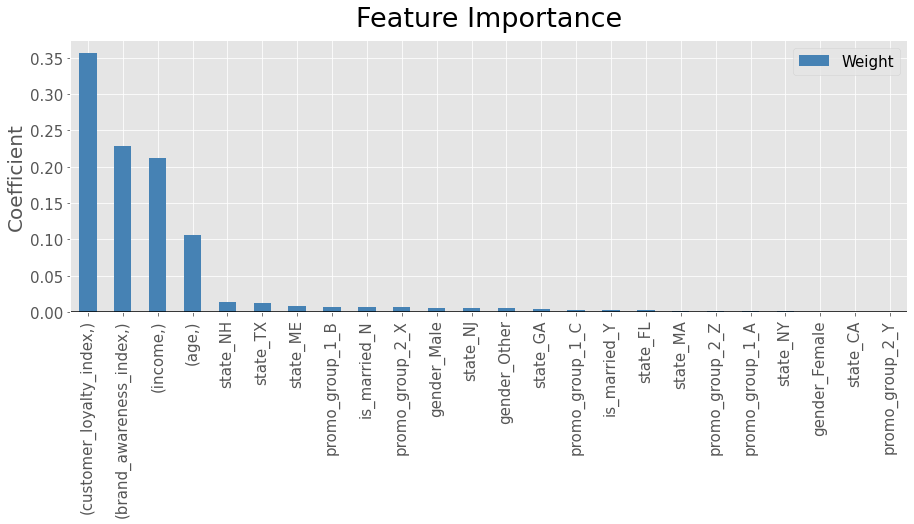

In [9]:
plt.style.use('ggplot')

gbst.fit(X_train, y_train)
importances = pd.DataFrame((gbst.feature_importances_),
                           index=X_train.columns,
                           columns=['Gradient Boosting']).sort_values('Gradient Boosting',
                                                                 ascending=False).rename(columns={'index': 'Feature', 'Gradient Boosting': 'Weight'})

print ()
print ('\033[1m'+'Feature Weights:'+'\033[0m')
print (display(importances.head(30)))



importances.plot(kind='bar', figsize=(15,5), color='steelblue')
plt.title('Feature Importance', fontsize = 27, y = 1.03, color='black')
plt.ylabel('Coefficient', fontsize = 20)
plt.yticks(fontsize = 15)
plt.axhline(0, color='black')
plt.xticks(rotation=90, fontsize = 15)

plt.legend(fontsize = 15)
plt.show()

The best predictors of revenue are customer loyalty, brand awareness, income, age.

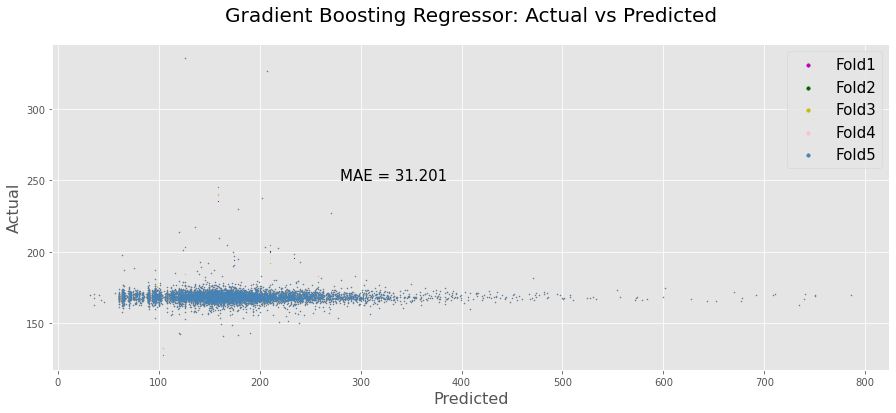

In [13]:
# from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=0)
scores = cross_val_score(gbst, X_train, y_train, cv=cv,scoring='neg_median_absolute_error')

plt.style.use('ggplot')
plt.figure(figsize=(15,6))
plt.xlabel('Predicted', fontsize=16)
plt.ylabel('Actual', fontsize=16)
plt.title('Gradient Boosting Regressor: Actual vs Predicted', fontsize = 20, y = 1.05)


def do_plot(model, m=None):
    for fold, color in zip(cv.split(X), ['m', 'darkgreen', 'y','pink', 'steelblue']):
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        plt.scatter(y_test, y_pred, color=color,s=.5 )
        plt.legend(["Fold1", 'Fold2','Fold3',"Fold4", 'Fold5'], fontsize = 15,markerscale=5)
#     plt.plot([y_pred.min(), y_pred.max()], [y_pred.min(), y_pred.max()],color='black', linewidth=1)
    plt.text(280,250, "MAE = "+str(m), fontsize=15)
do_plot(gbst, abs(scores.mean().round(3)))

However, as we can see my model did not predict very well  as my scatter plot did follow horizontal line of actual vs predicted values. 

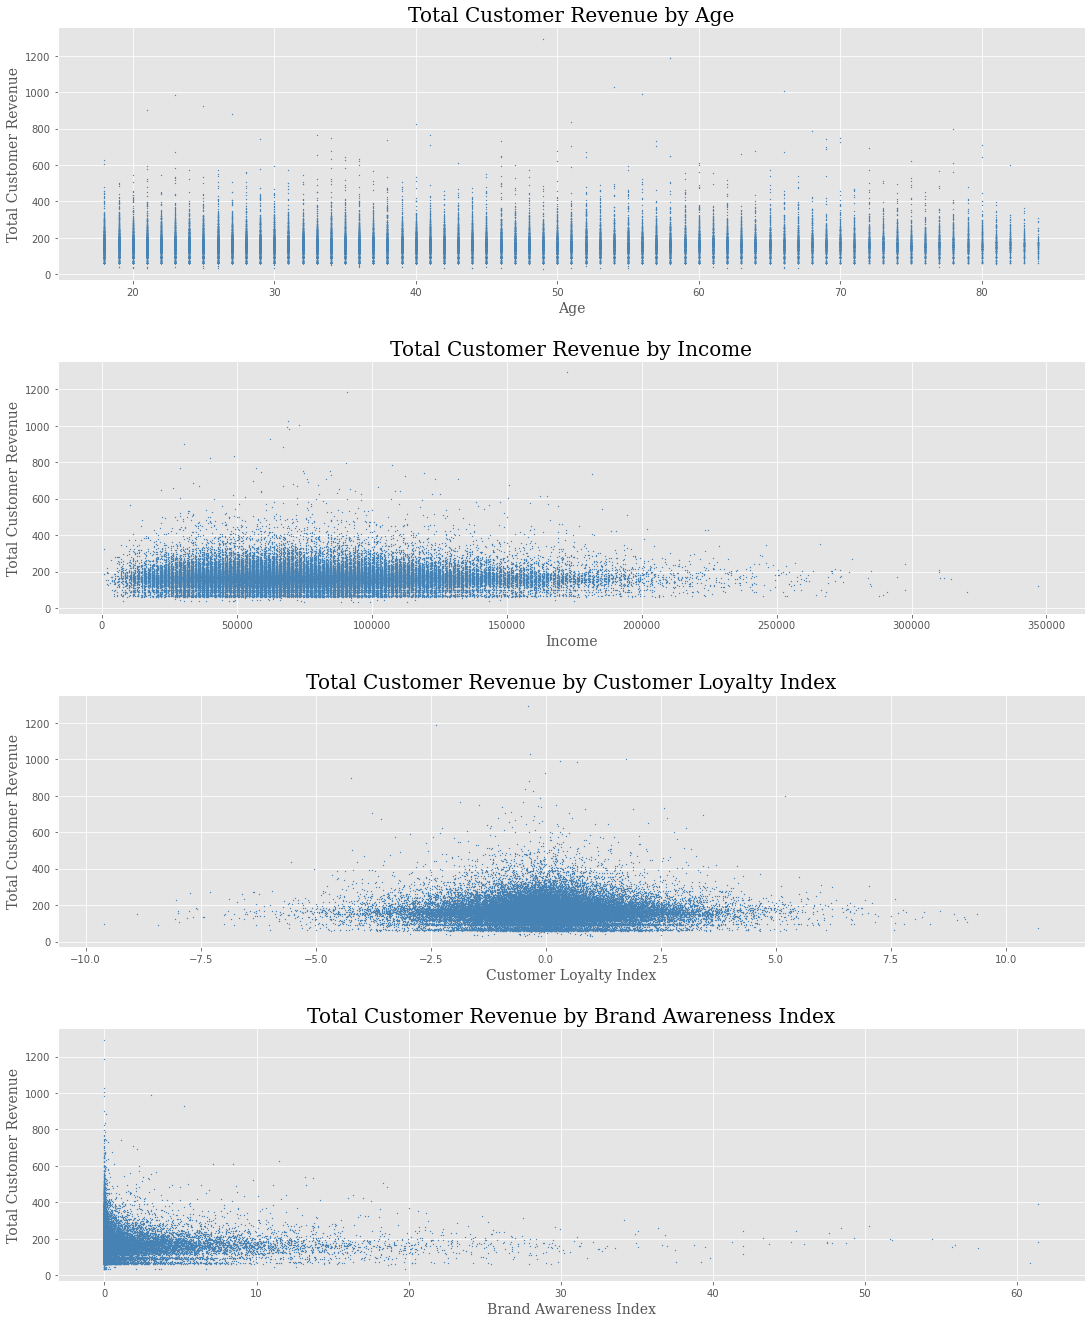

In [11]:
plt.style.use('ggplot')
fig, axes = plt.subplots(nrows=4,ncols=1, figsize=(15,18))
plt.tight_layout(h_pad=6)
cont=cont
titles=['Age','Income',\
        'Customer Loyalty Index','Brand Awareness Index']
for ax,feature, title in zip(axes.flat,cont, titles):
        ax.scatter(df[feature], df.transaction_value, color='steelblue',s=.7 )
        ax.set_title('Total Customer Revenue by '+ title ,fontsize=20,family='serif')
        ax.set_xlabel(title,size =14,family='serif')
        ax.set_ylabel('Total Customer Revenue',size =14,family='serif')
plt.show()  

When I performed my EDA, it looked like total revenue did not have large differences between groups.here were not any direct relationships between Age, Income, Customer Loyalty Index, and Brand Awareness Index. 

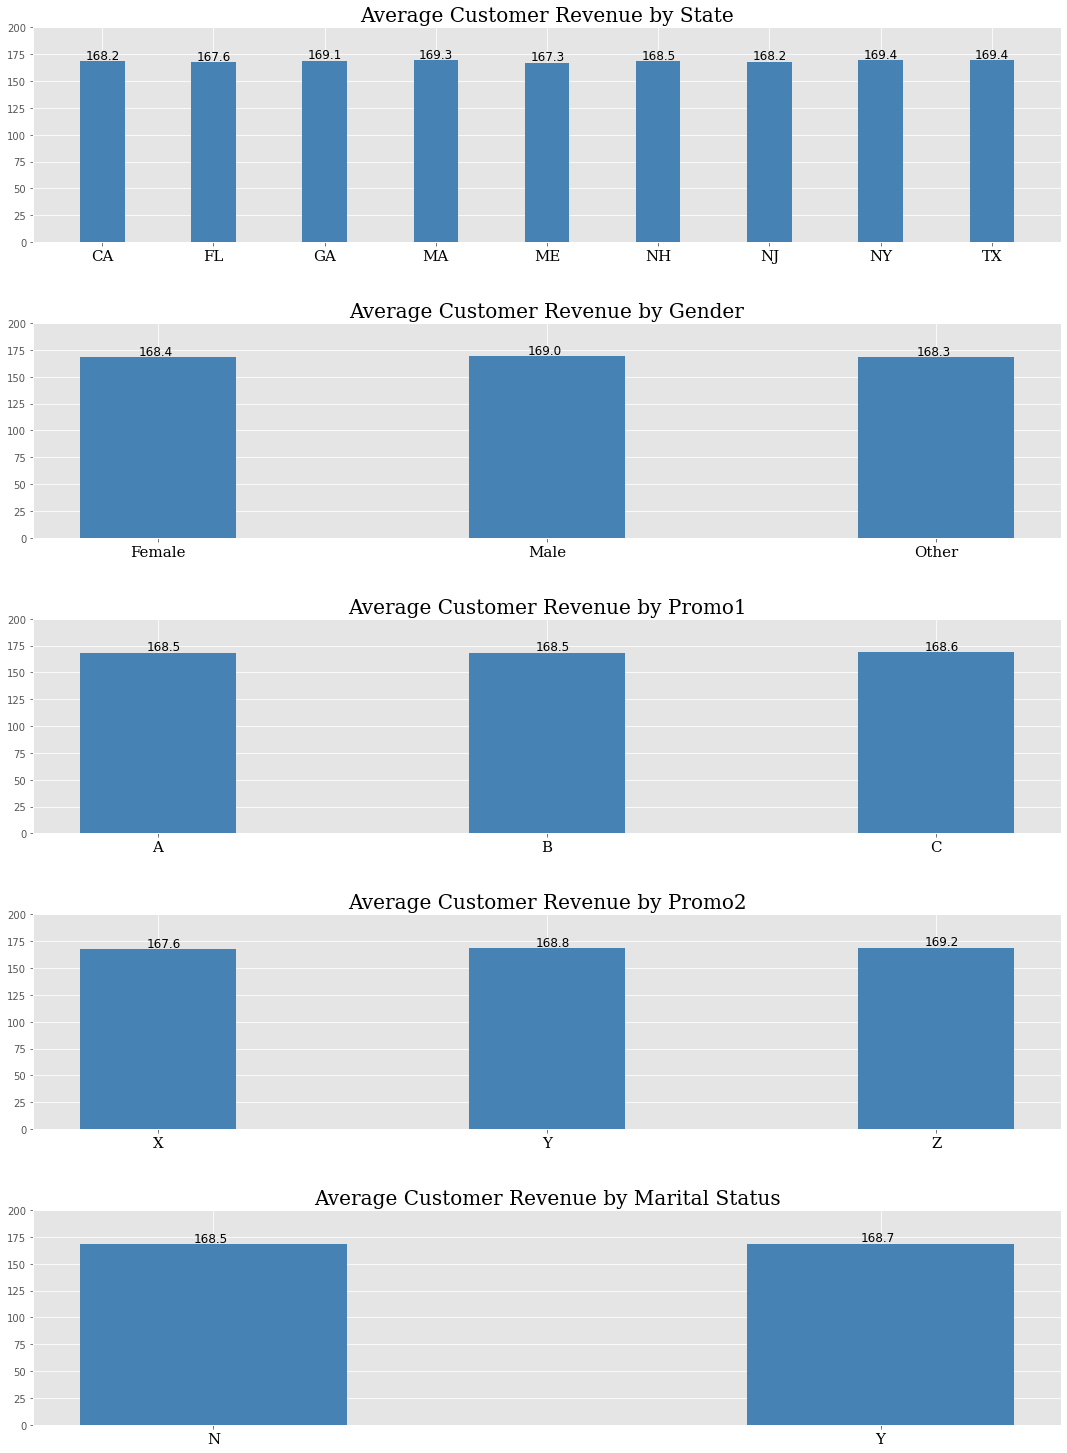

In [12]:
plt.style.use('ggplot')

fig, axes = plt.subplots(nrows=5,ncols=1, figsize=(15,20))
plt.tight_layout(h_pad=6)
cat=['state', 'gender', 'promo_group_1', 'promo_group_2','is_married']
titles=['State','Gender',\
        'Promo1','Promo2','Marital Status']

for ax,feature, title in zip(axes.flat,cat, titles):
    df3=pd.pivot_table(df,  values=['transaction_value'], \
                   columns=feature,aggfunc='mean').T.reset_index()
    features = list(df3[feature])
    values = list(df3['transaction_value'])
    ax.bar(features, values, color ='steelblue',
        width = 0.4)
    ax.set_title('Average Customer Revenue by '+ title ,fontsize=20,family='serif')
    ax.set_ylim([0,200])
    if feature=='state':
        for i in ax.patches:
            ax.text( i.get_x()+.05,i.get_height()+2, \
                '{:.1f}'.format(i.get_height()), fontsize=12)
    elif feature=='gender':
            for i in ax.patches:
                ax.text( i.get_x()+.15,i.get_height()+2, \
                '{:.1f}'.format(i.get_height()), fontsize=12)
    elif feature in ['Promo1', 'Promo2']:
        for i in ax.patches:
            ax.text( i.get_x()+.2,i.get_height()+2, \
                '{:.1f}'.format(i.get_height()), fontsize=12)
    else:
            for i in ax.patches:
                ax.text( i.get_x()+.17,i.get_height()+2, \
                '{:.1f}'.format(i.get_height()), fontsize=12)
    ax.set_xticklabels(df3[feature],size =15,family='serif', \
                       color='black', rotation='horizontal')
plt.show()

Categorical data had very week relationship with total revenue as well. 

## What I would do if I had more time

1)	I would try to estimate my CLTV using different approaches. However, I am not sure whether it would help as one third of my data were first-time buyers and, thus, had no retention period as there were no data to estimate it. Also, even we look at the relationship between our predictors and outcome variable, we can see that there is very week relationship among them. And it makes sense, since one third of our data are new buyers and thus have no lifetime value that can be estimated yet. 
2)	I would do research and look for better models to handle this problem. I would definitely avoid any general linear models.  This data needs a probabilistic model to do estimations. One model that I recently learned about is Buy Till You Die model that can be a very good solution to this problem. I would research for any other non-parametric or probabilistic model to predict the data. Unfortunately, since my previous projects were not associated with an estimation of CLTV, I am not aware of those models at this point. However, based on my observations of the data, I think only this kind of model can handle this kind of data. The facts that one third of the customers are new buyers and the other portion of the customers might not buy anymore in the future are needed to be taken in consideration by our model. Regular regressors and machine learning models are not suited for this kind of problems.  
